In [8]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [30]:
def exp_decay(z, A, B, C):
    return A * np.exp(-(z)/B) + C


In [31]:
folder = Path(r"/home/ubuntu/SMRR/garfield_tasks/Rx_build/Outputs_Kr")

In [32]:
data = {
    "Energy" : np.linspace(1,20,20)*1000,
    "z" : []
}

In [33]:
files = [f for f in folder.iterdir() if f.is_file()]

for f in files:
    temp = np.genfromtxt(f, delimiter='\t')
    mask = np.where(temp.T[1]==0)[0]
    data["z"].append(temp.T[4][mask]+0.29)


/tmp/ipykernel_7965/1028032674.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


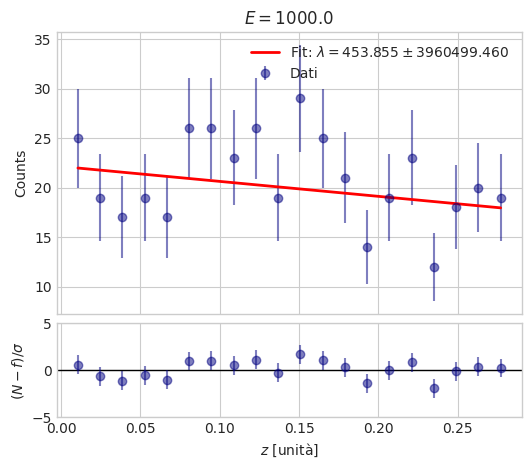

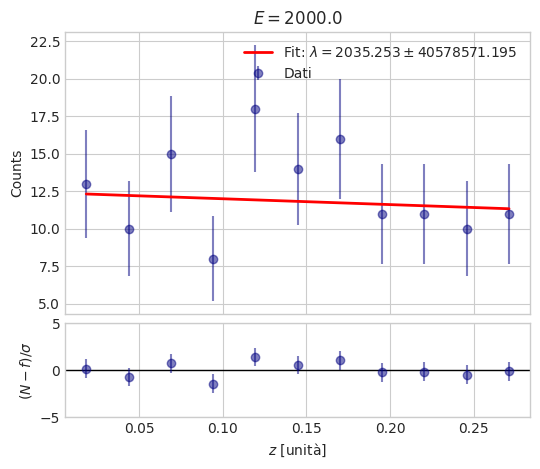

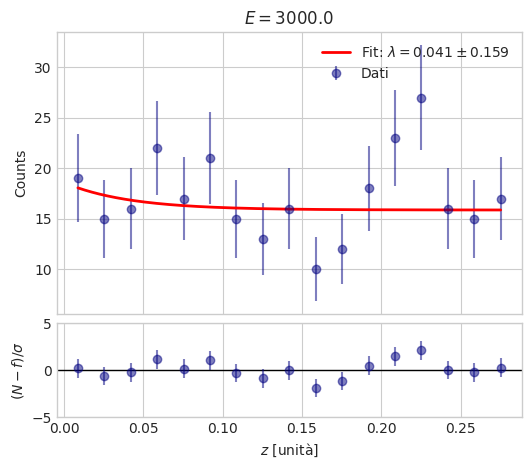

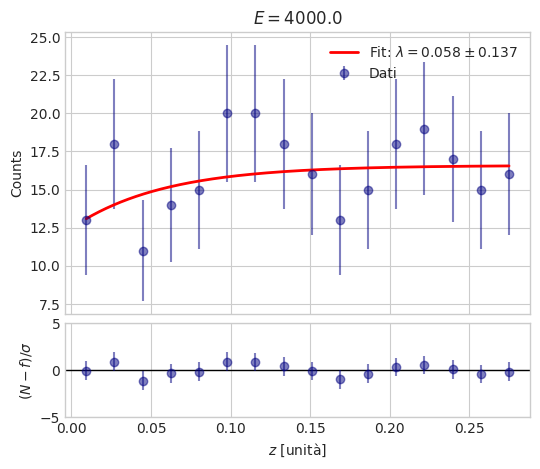

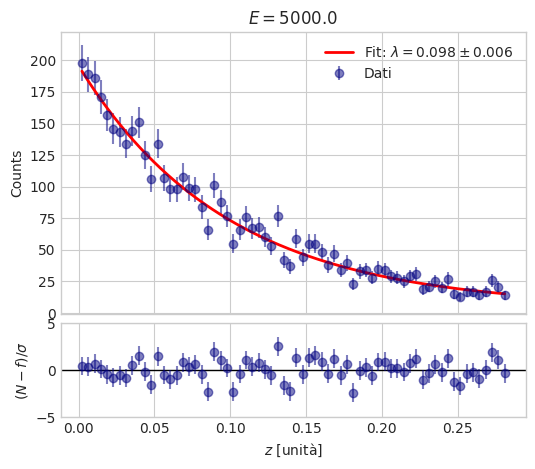

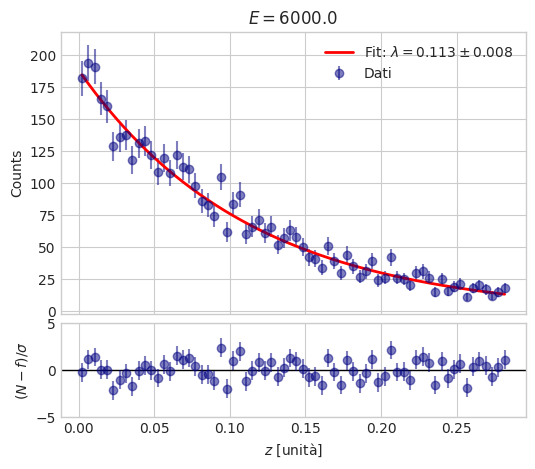

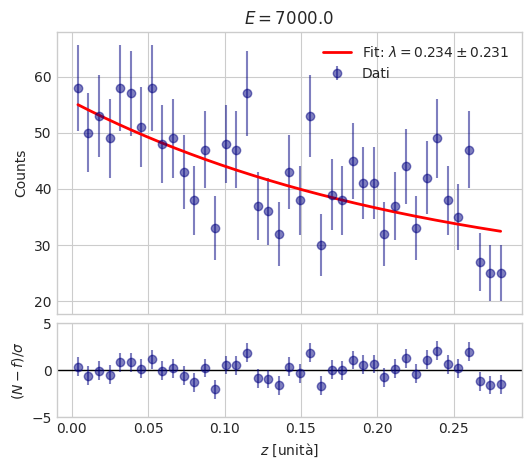

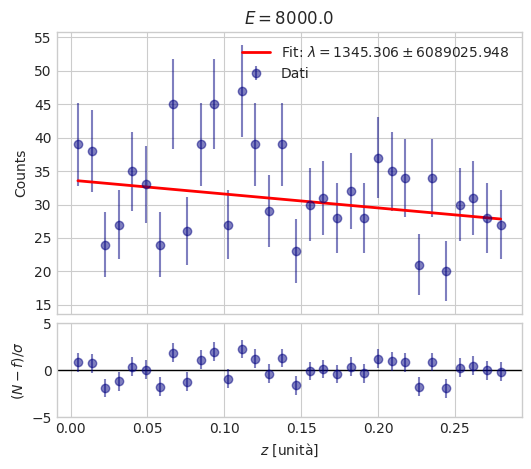

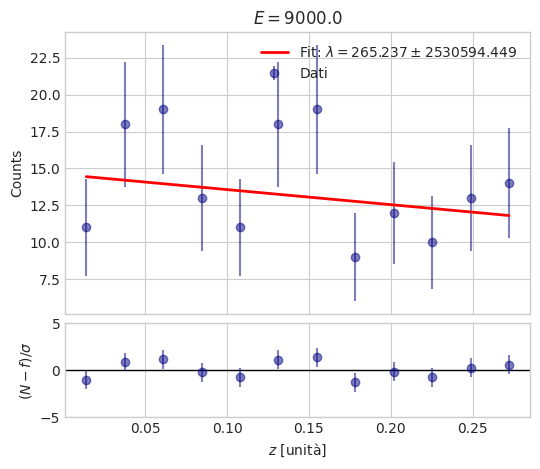

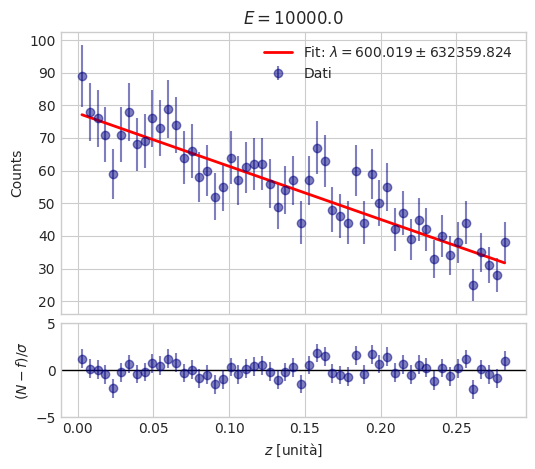

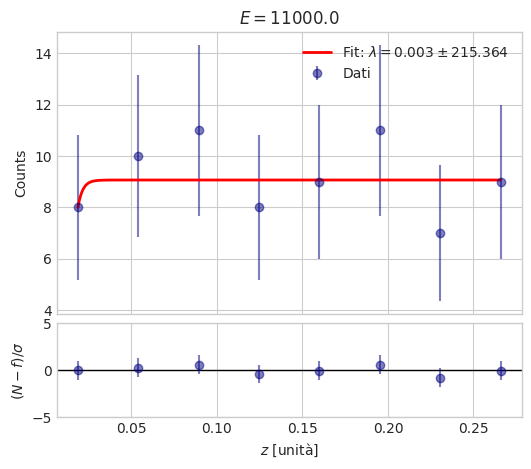

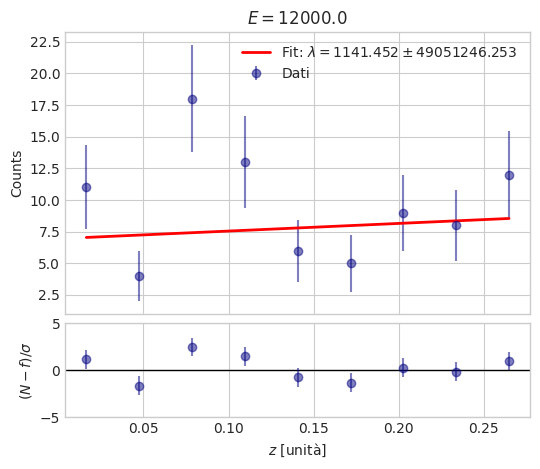

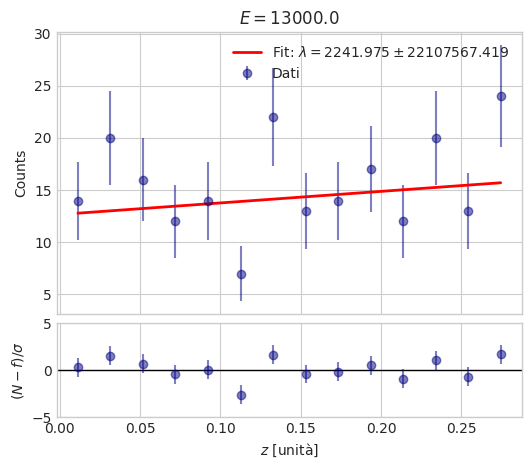

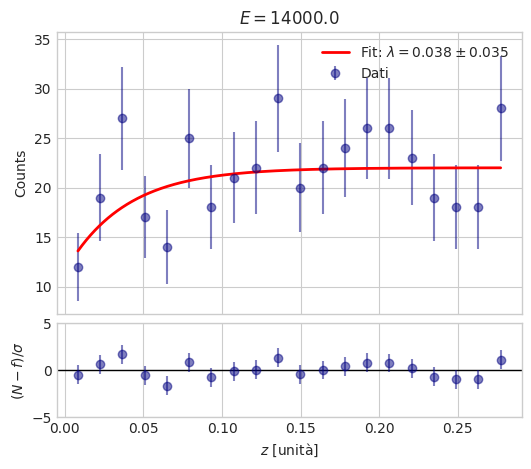

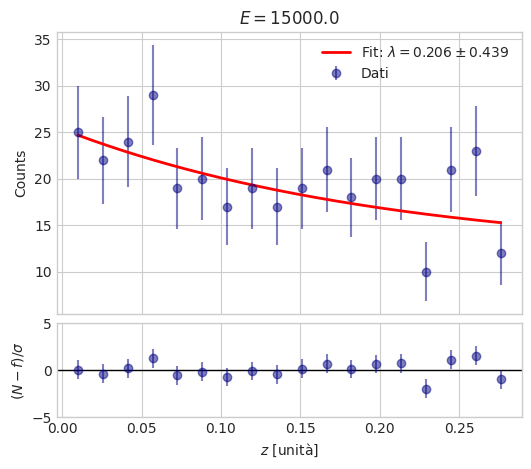

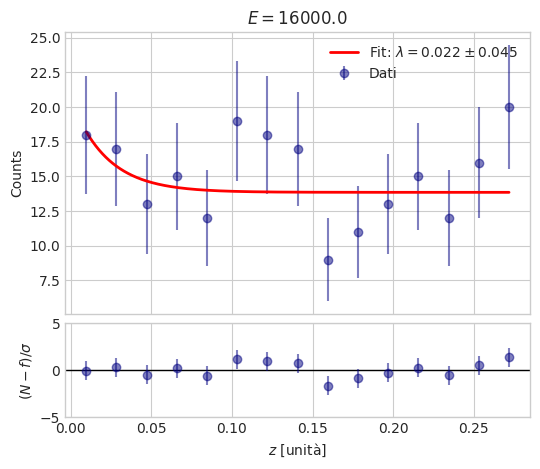

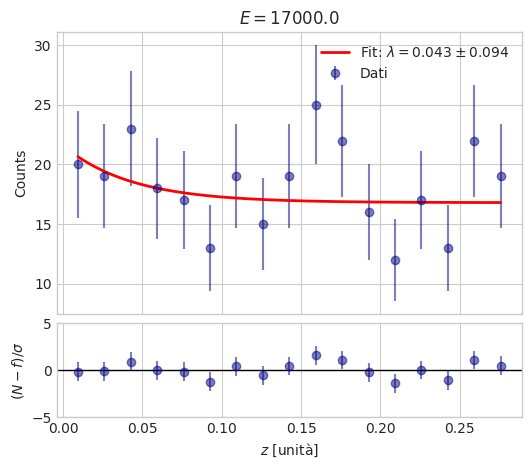

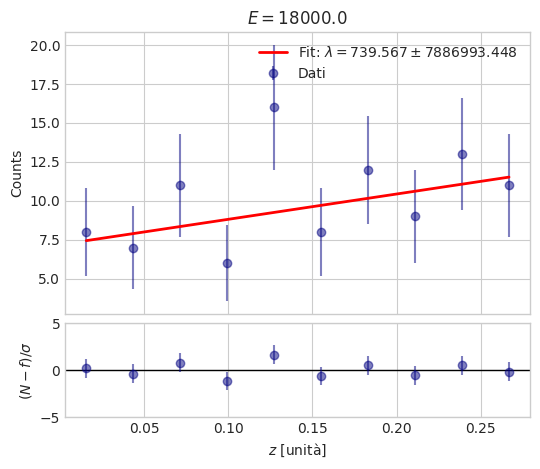

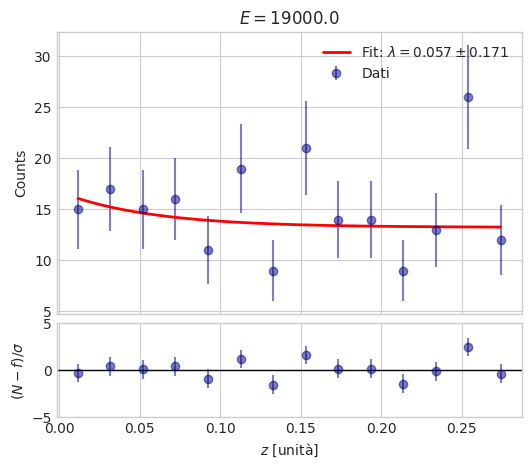

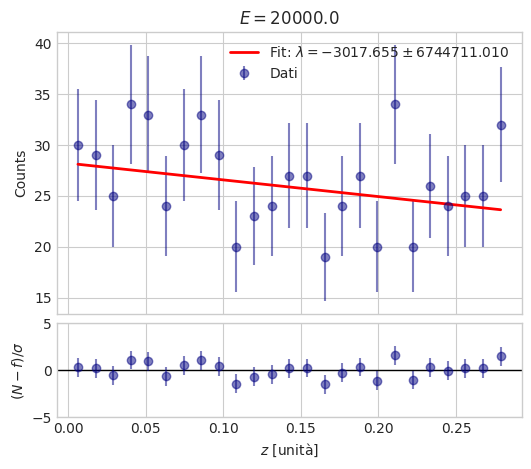

In [38]:
plt.style.use("seaborn-v0_8-whitegrid")

for E, z in zip(data["Energy"], data["z"]):

    z = np.asarray(z)

    bins = int(np.sqrt(len(z)))
    counts, edges = np.histogram(z, bins=bins, density=False)
    centers = 0.5 * (edges[1:] + edges[:-1])

    # Errori Poissoniani
    sigma = np.sqrt(counts)
    sigma[sigma == 0] = 1.0   # evita divisioni per zero

    # Guess iniziali
    off_guess = counts[-1]
    A_guess = counts[0] - off_guess
    lambda_guess = 0.1
    p0 = [A_guess, lambda_guess, off_guess]

    popt, pcov = curve_fit(
        exp_decay,
        centers,
        counts,
        p0=p0,
        sigma=sigma,
        absolute_sigma=True
    )

    A, lamb, off = popt
    lamb_err = np.sqrt(pcov[1, 1])

    # Fit
    z_fit = np.linspace(centers.min(), centers.max(), 1000)
    y_fit = exp_decay(z_fit, *popt)

    # Residui normalizzati
    model_counts = exp_decay(centers, *popt)
    residuals = (counts - model_counts) / sigma

    # ================= FIGURA =================
    fig, (ax, ax_res) = plt.subplots(
        2, 1,
        figsize=(6, 5),
        sharex=True,
        gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
    )

    # --- Dati + fit ---
    ax.errorbar(
        centers, counts, yerr=sigma,
        fmt="o", color="navy", label="Dati", alpha=0.5
    )
    ax.plot(z_fit, y_fit, "r-", lw=2,
            label=rf"Fit: $\lambda = {lamb:.3f} \pm {lamb_err:.3f}$")

    ax.set_ylabel("Counts")
    ax.set_title(rf"$E = {E}$")
    ax.legend()

    # --- Residui ---
    ax_res.axhline(0, color="k", lw=1)
    ax_res.errorbar(
        centers, residuals, yerr=np.ones_like(residuals),
        fmt="o", color="navy", alpha=0.5
    )

    ax_res.set_ylabel(r"$(N - f)/\sigma$")
    ax_res.set_xlabel(r"$z$ [unità]")
    ax_res.set_ylim(-5, 5)

    plt.tight_layout()
    plt.show()
